# Aanbod huurwoningen in Nederland

In [23]:
import pandas as pd
import numpy as np

pararius = pd.read_csv("../data/pararius_listings.csv")
pararius.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2112 entries, 0 to 2111
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Link                2112 non-null   object 
 1   Huurprijs           1886 non-null   object 
 2   Locatie             1886 non-null   object 
 3   m2                  2110 non-null   object 
 4   Kamers              2110 non-null   object 
 5   Interieur           1794 non-null   object 
 6   Huurovereenkomst    929 non-null    object 
 7   Type woning         0 non-null      float64
 8   Bouwjaar            1771 non-null   object 
 9   Badkamers           1448 non-null   float64
 10  Faciliteiten        1183 non-null   object 
 11  Balkon              1686 non-null   object 
 12  Tuin                1578 non-null   object 
 13  Omschrijving tuin   252 non-null    object 
 14  Energie label       1529 non-null   object 
 15  Opslag              1130 non-null   object 
 16  Parker

### Opschonen

Om de dataset te kunnen analyseren moeten eerst een aantal kolommen een ander datatype krijgen, worden opgeschoond en waar nodig worden bijgevuld:

1. Er zijn twee links die geen waarden hebben voor `Huurprijs`, `Locatie` en `Beschrijving`. Deze links werken niet meer dus we verwijderen deze rijen.
2. De `Huurprijs` kolom moet worden omgezet naar een `float` datatype.
    - Sommige van deze waarden worden als volgt weergeven: '€ 1.075 - 1.775 per month'. In dat geval berekenen we het gemiddelde van de prijs.
    - Voor sommige huurwoningen moet je de prijs opvragen, de waarde is dan 'Price on request'. Voor dat geval voegen we een nieuwe kolom toe `Verzoek` met als waarde `True` of `False`.
3. De `m2` moet ook worden omgezet naar `float`.
    - Hier geldt dezelfde uitzondering als bij de huurprijs. We berekenen ook het gemiddelde aantal vierkante meter in dit geval.
4. De `Kamers` kolom moet alleen een cijfer bevatten en worden omgezet naar `int` datatype.
5. De `Bouwjaar` kolom moet worden omgezet naar `int` datatype.
6. De `Tuin` kolom bevat soms het aantal vierkante meter. Dit willen we in een aparte kolom `Tuin m2` hebben.
7. De `Locatie` kolom bevat een postcode en de naam van de buurt. Dit gaan we opsplitsen in twee kolommen.
8. De URL in de `Link` kolom bevat de stad waarin de woning staat. Hiervoor maken we een nieuwe kolom `Stad`.

In [24]:
import re

def schoon_huurprijs(prijs):
    """Functie om de 'Huurprijs' kolom op te schonen."""
    if isinstance(prijs, float) or prijs is None:
        return prijs
    
    if "Price on request" in str(prijs):
        return None # Lege waarde voor de huurprijs
    
    prijs = prijs.replace("€", "").replace("per month", "").replace(",", "").strip()

    # Check of de huurprijs twee prijzen kan zijn
    if "-" in prijs:
        laag, hoog = prijs.split("-")
        laag = float(laag.strip())
        hoog = float(hoog.strip())
        return (laag + hoog) / 2 # Bereken het gemiddelde van de twee prijzen
    else:
        return float(prijs)


def schoon_m2(waarde):
    """Functie om de 'm2' kolom op te schonen."""
    if pd.isnull(waarde):
        return None
    
    waarde = waarde.replace("m²", "").replace("㎡", "").strip()

    # Bereken het gemiddelde als er twee waarden voor 'm2' zijn
    if "-" in waarde:
        laag, hoog = waarde.split("-")
        laag = laag.strip()
        hoog = hoog.strip()
        return (float(laag) + float(hoog)) / 2
    else:
        return float(waarde)


def schoon_kamers(waarde):
    """Functie om de 'Kamers' kolom op te schonen."""
    return int(waarde.replace("rooms", "").replace("room", "").strip())


def krijg_tuin_m2(waarde):
    """Functie die het aantal vierkante meter uit de omschrijving van de tuin haalt."""
    match = re.search(r'\d+', str(waarde))
    return int(match.group()) if match else None


def krijg_buurt(locatie):
    """Functie die de 'Locatie' kolom opsplits in de postcode en buurt."""
    if pd.isnull(locatie):
        return None
    
    if "(" in locatie and ")" in locatie:
        buurt = locatie.split("(")[-1].split(")")[0].strip()
        return buurt
    else:
        return None


def krijg_stad(link):
    """Functie die de stadsnaam uit de URL in de 'Link' kolom haalt."""
    if pd.isnull(link):
        return None
    
    # Splits de URL op en haal de naam van de stad op
    try:
        return link.split("/")[4] #
    except IndexError:
        return None

In [25]:
# Vind de lege rijen en verwijder ze
lege_rijen = pararius[pararius[['Huurprijs', 'Locatie', 'Beschrijving']].isnull().all(axis=1)]
pararius = pararius.drop(lege_rijen.index)

# Huurprijs opschonen
pararius["Verzoek"] = pararius["Huurprijs"].apply(lambda x: True if "Price on request" in str(x) else False)
pararius["Huurprijs"] = pararius["Huurprijs"].apply(schoon_huurprijs)

# Vierkante meter opschonen
pararius["m2"] = pararius["m2"].apply(schoon_m2)

# Kamers opschonen
pararius["Kamers"] = pararius["Kamers"].apply(schoon_kamers)

# Bouwjaar omzetten naar integer
pararius["Bouwjaar"] = pd.to_numeric(pararius["Bouwjaar"], errors='coerce')

# Oppervlakte van de tuin achterhalen 
pararius['Tuin m2'] = pararius['Tuin'].apply(krijg_tuin_m2)

# Locatie opschonen
pararius['Buurt'] = pararius['Locatie'].apply(krijg_buurt)
pararius['Locatie'] = pararius['Locatie'].apply(lambda x: x.split('(')[0].strip() if pd.notnull(x) else x)

# Voeg de 'Stad' kolom toe
pararius["Stad"] = pararius["Link"].apply(krijg_stad)
pararius["Stad"] = pararius["Stad"].str.replace('-', ' ')

pararius.head()

,Link,Huurprijs,Locatie,m2,Kamers,Interieur,Huurovereenkomst,Type woning,Bouwjaar,Badkamers,...,Energie label,Opslag,Parkeren,Type parkeerplaats,Garage,Beschrijving,Verzoek,Tuin m2,Buurt,Stad
0,https://www.pararius.com/apartment-for-rent/am...,1900.0,1012 ES,65.0,2,Furnished,Unlimited period,NaN,1950.0,1.0,...,NaN,Not present,No,NaN,No,"Description\r\nGreat Location , 1 bedroom apt ...",False,NaN,Burgwallen-Oude Zijde,amsterdam
1,https://www.pararius.com/apartment-for-rent/zo...,2100.0,2718 SJ,106.0,3,Upholstered,Unlimited period,NaN,1996.0,1.0,...,A+,Not present,Yes,Public,No,Description\r\nUnfurnished 4-room apartment lo...,False,NaN,Lansinghage c.a.,zoetermeer
2,https://www.pararius.com/apartment-for-rent/de...,800.0,2563 BH,35.0,2,Upholstered,Unlimited period,NaN,1900.0,1.0,...,NaN,Not present,Yes,Permit,No,Description\r\nSuper nice apartment on Laan va...,False,NaN,Valkenboskwartier,den haag
3,https://www.pararius.com/apartment-for-rent/ti...,1725.0,5038 BW,84.0,2,Furnished,Temporary rental,NaN,2007.0,1.0,...,A,Not present,Yes,Garage,Yes,Description\r\nCan be rented for a maximum of ...,False,NaN,Binnenstad Oost,tilburg
6,https://www.pararius.com/house-for-rent/noordw...,1950.0,2201 WH,113.0,5,Furnished,Unlimited period,NaN,1986.0,1.0,...,B,Not present,Yes,Public,No,Description\r\nFor Rent: Temporary Home in Noo...,False,NaN,Vinkeveld Zuid,noordwijk zh


## 1. WOZ-waarde

Aangezien Pararius niet de WOZ-waarde van huurwoningen weergeeft, zullen we per buurt naar de **gemiddelde WOZ-waarde** moeten kijken. De meest recente data over gemiddelde WOZ-waarden in Nederland komt uit 2023 ([CBS, 2023](https://opendata.cbs.nl/portal.html?_la=nl&_catalog=CBS&tableId=85618NED&_theme=244)). 

In [26]:
buurtcodes = pd.read_csv("../data/cbs/buurtcodes.csv")
woz_waarden = pd.read_csv("../data/cbs/woz_waarden.csv")

woz_waarden.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18116 entries, 0 to 18115
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          18116 non-null  int64  
 1   Key                         18116 non-null  object 
 2   Gemiddelde WOZ              16156 non-null  float64
 3   Meest voorkomende postcode  18116 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 566.3+ KB


### Opschonen

Het dataframe `woz_waarden` bevat alleen codes voor de gemeente, stad of buurt en niet de namen hiervan. Waar deze codes voor staan is terug te zien in het `buurtcodes` dataframe. Deze zullen we dus samenvoegen om duidelijker de WOZ-waarde per buurt te kunnen zien.

In [27]:
# Alle spaties/witregels strippen
woz_waarden = woz_waarden.map(lambda x: x.strip() if isinstance(x, str) else x)
buurtcodes = buurtcodes.map(lambda x: x.strip() if isinstance(x, str) else x)

# Haal de gemeentenaam uit de beschrijving van de wijk of buurt
buurtcodes["Gemeente"] = buurtcodes["Description"].str.extract(r"\'([^\']+)\'(?:[^'])*$")

# Missende waarden opvullen
woz_waarden['Meest voorkomende postcode'] = woz_waarden['Meest voorkomende postcode'].replace('.', '')

# Voeg de buurtnaam toe aan de dataframe met WOZ-waarden
merged_df = woz_waarden.merge(buurtcodes[["Key", "Title", "Gemeente"]], on="Key", how="left")

woz_waarden["Key"] = merged_df["Title"]
woz_waarden = merged_df.drop(columns=['ID'])
woz_waarden['Gemeente'] = woz_waarden['Gemeente'].str.lower()

# Voeg de gemiddelde WOZ-waarde toe per buurt
pararius = pararius.merge(
    woz_waarden[["Title", "Gemeente", "Gemiddelde WOZ"]], 
    left_on=["Buurt", "Stad"], 
    right_on=["Title", "Gemeente"], 
    how="left"
)

# Alternatieve methode voor wanneer de gemeentenaam anders is dan de stadsnaam
pararius = pararius.merge(
    woz_waarden[["Title", "Gemiddelde WOZ"]],
    left_on="Buurt",
    right_on="Title",
    how="left",
    suffixes=("", "_alternatief")
)

pararius["Gemiddelde WOZ"] = pararius["Gemiddelde WOZ"].fillna(pararius["Gemiddelde WOZ_alternatief"])
pararius = pararius.drop(columns=["Title", "Gemiddelde WOZ_alternatief", "Gemeente", "Title_alternatief"])

# WOZ-waarde multipliceren met 1000
pararius["Gemiddelde WOZ"] = pararius["Gemiddelde WOZ"] * 1000

pararius.head()

,Link,Huurprijs,Locatie,m2,Kamers,Interieur,Huurovereenkomst,Type woning,Bouwjaar,Badkamers,...,Opslag,Parkeren,Type parkeerplaats,Garage,Beschrijving,Verzoek,Tuin m2,Buurt,Stad,Gemiddelde WOZ
0,https://www.pararius.com/apartment-for-rent/am...,1900.0,1012 ES,65.0,2,Furnished,Unlimited period,NaN,1950.0,1.0,...,Not present,No,NaN,No,"Description\r\nGreat Location , 1 bedroom apt ...",False,NaN,Burgwallen-Oude Zijde,amsterdam,557000.0
1,https://www.pararius.com/apartment-for-rent/zo...,2100.0,2718 SJ,106.0,3,Upholstered,Unlimited period,NaN,1996.0,1.0,...,Not present,Yes,Public,No,Description\r\nUnfurnished 4-room apartment lo...,False,NaN,Lansinghage c.a.,zoetermeer,489000.0
2,https://www.pararius.com/apartment-for-rent/de...,800.0,2563 BH,35.0,2,Upholstered,Unlimited period,NaN,1900.0,1.0,...,Not present,Yes,Permit,No,Description\r\nSuper nice apartment on Laan va...,False,NaN,Valkenboskwartier,den haag,318000.0
3,https://www.pararius.com/apartment-for-rent/ti...,1725.0,5038 BW,84.0,2,Furnished,Temporary rental,NaN,2007.0,1.0,...,Not present,Yes,Garage,Yes,Description\r\nCan be rented for a maximum of ...,False,NaN,Binnenstad Oost,tilburg,266000.0
4,https://www.pararius.com/house-for-rent/noordw...,1950.0,2201 WH,113.0,5,Furnished,Unlimited period,NaN,1986.0,1.0,...,Not present,Yes,Public,No,Description\r\nFor Rent: Temporary Home in Noo...,False,NaN,Vinkeveld Zuid,noordwijk zh,402000.0


## 2. Punten toekennen

Het [woningwaarderingsstelsel](https://www.huurcommissie.nl/huurcommissie-helpt/beleidsboeken_html/waarderingsstelsel-zelfstandige-woonruimte/bijlage-1) van de Huurcommissie kent punten toe op basis van bepaalde eigenschappen van de woning (oppervlakte, verwarming, energieprestatie, etc.). Om precies het aantal punten vast te stellen zul je de woning daadwerkelijk moeten zien en opmeten. Met onze dataset kunnen we slechts een benadering maken op basis van de aspecten die in de advertenties op Pararius worden vermeld.

*De puntentelling voor een huurwoning wordt voornamelijk bepaald door de oppervlakte, het energie label en de WOZ-waarde.*

### 2.1 Berekening punten oppervlakte

- Vertrekken worden gewaardeerd met 1 punt per vierkante meter.
- Overige ruimten worden gewaardeerd met 0,75 punt per vierkante meter.
- We gaan er voor deze berekening uit dat 75% van de aangegeven oppervlakte bestaat uit vertrekken.

In [28]:
pararius["Punten oppervlakte"] = (pararius["m2"] * 0.75) + (pararius["m2"] * 0.25 * 0.75)

### 2.2 Berekening punten verwarming

- Een verwarmd vertrek wordt gewaardeerd met 2 punten.
- Verwarming per overige ruimte en verkeersruimte wordt gewaardeerd met 1 punt (maximaal 4 punten).

In [29]:
# Punten toekennen per vertrek
pararius["Punten verwarming"] = pararius["Kamers"] * 2

# Punten toekennen per overige ruimte
pararius["Punten verwarming"] += pararius["Kamers"] * 1

# Maximaal van 4 punten toekennen als ruimten verwarmde vloeren hebben
pararius["Punten verwarming"] += pararius['Beschrijving'].str.contains('underfloor heating', case=False, na=False) * 4

### 2.3 Berekening punten sanitair

- 2 punten wordt gegeven voor een toilet in een badkamer.
- 1 punt wordt gegeven voor een wastafel.
- 4 punten worden gegeven voor een douche.
- 6 punten worden gegeven voor een bad.

In [30]:
pararius["Badkamers"] = pararius["Badkamers"].fillna(1) # Ga ervan uit dat elke woning minimaal 1 badkamer heeft

# Punten toevoegen voor een badkamer met toilet
pararius["Punten sanitair"] = pararius["Badkamers"] * 2

# Punten toevoegen voor wastafels (keuken + aantal badkamers)
pararius["Punten sanitair"] += pararius["Badkamers"] + 1

# Punten geven voor een douche
pararius['Punten sanitair'] += (
    (pararius['Faciliteiten'].str.contains('shower', case=False, na=False) | 
     pararius['Beschrijving'].str.contains('shower', case=False, na=False)) * 4
)

# Punten geven voor een bad
pararius['Punten sanitair'] += (
    (pararius['Faciliteiten'].str.contains(r'\bath\b', case=False, na=False, regex=True) | 
     pararius['Beschrijving'].str.contains(r'\bath\b', case=False, na=False, regex=True)) * 6
)

### 2.4 Berekening punten buitenruimten

- Voor privé-buitenruimten worden in ieder geval 2 punten toegekend en vervolgens per vierkante meter 0,35 punt.
- Een aftrek van 5 punten wordt toegepast als de woning geen buitenruimten heeft.
- Maximaal 15 punten worden toegekend voor buitenruimten.

In [31]:
# Punten toekennen als er een buitenruimte is
buiten_punten = pararius[['Tuin', 'Balkon']].fillna("Not present").apply(
    lambda x: 2 if (x['Tuin'] != "Not present" or x['Balkon'] != "Not present") else 0, axis=1
)

# Punten toekennen per vierkante meter van de tuin
tuin_m2_punten = pararius['Tuin m2'].fillna(0) * 0.35

# Zorg dat maximaal 15 punten kunnen worden toegekend
buiten_punten_totaal = (buiten_punten + tuin_m2_punten).clip(upper=15)
pararius["Punten buitenruimten"] = buiten_punten_totaal

# Punten aftrekken als de woning geen buitenruimten heeft
pararius['Punten buitenruimten'] -= pararius.apply(lambda row: 5 if row['Balkon'] == "Not present" and row['Tuin'] == "Not present" else 0, axis=1)

### 2.5 Berekening punten energie label

Bij de berekening op basis van de energieprestatie hangt het puntenaantal af van de oppervlakte van de woning of het bouwjaar (als het energie label ontbreekt). Zie de onderstaande dictionaries voor de puntentoekenning. 

*TO DO: Indien de woning bestaat of deel uitmaakt van een monument, worden voor de energielabels E, F, en G geen minpunten toegekend.*

In [32]:
# Algemene puntentoekenning
energie_punten = {
    "A++++": 62,
    "A+++": 57,
    "A++": 52,
    "A+": 47,
    "A": 41,
    "B": 34,
    "C": 22,
    "D": 14,
    "E": -4,
    "F": -9,
    "G": -15
}

# Woningen met een oppervlakte kleiner dan 25 m2
energie_punten_25m2 = {
    "A++++": 62,
    "A+++": 62,
    "A++": 60,
    "A+": 55,
    "A": 49,
    "B": 42,
    "C": 36,
    "D": 32,
    "E": -4,
    "F": -9,
    "G": -15
}

# Puntenaantal op basis van het bouwjaar
bouwjaar_punten = {
    (2002, float('inf')): 41,
    (2000, 2001): 34,
    (1992, 1999): 22,
    (1984, 1991): 14,
    (1979, 1983): -4,
    (1977, 1978): -9,
    (float('-inf'), 1976): -15
}

In [33]:
def energie_punten_toekennen(rij):
    """Functie om punten toe te kennen op basis van het energie label of bouwjaar"""
    if pd.notna(rij['Energie label']): 
        # Ken punten toe op basis van de oppervlakte van de woning en energie label
        if rij['m2'] < 25:
            return energie_punten_25m2.get(rij['Energie label'], 0)
        else:
            return energie_punten.get(rij['Energie label'], 0)
    else:
        # Kijk naar het bouwjaar als de woning geen energie label heeft
        for (start, end), punten in bouwjaar_punten.items():
            if start <= rij['Bouwjaar'] <= end:
                return punten
        return 0 # Ken 0 punten toe als het bouwjaar ook mist


# Punten toekennen op basis van het energie label
pararius['Punten energie'] = pararius.apply(energie_punten_toekennen, axis=1)

### 2.6 Berekening punten parkeerruimten

- Een privé parkeerplek in een afgesloten parkeergarage behorende tot het complex krijgt 9 punten.
- Een  privé parkeerplek buiten behorende tot het complex of de woning zonder dak krijgt 4 punten.

In [34]:
# Punten toekennen voor garages
pararius['Punten parkeerruimten'] = pararius.apply(
    lambda row: 9 if row['Garage'] == "Yes" and row['Type parkeerplaats'] == "On private land" else 0,
    axis=1
)

# Punten toekennen voor parkeerplekken buiten
pararius['Punten parkeerruimten'] = pararius.apply(
    lambda row: 4 if row['Garage'] == "No" and row['Type parkeerplaats'] == "On private land" else 0,
    axis=1
)

### 2.7 Berekening punten keuken

- Een ingebouwde koelkast krijgt 1 punt.
- Een ingebouwde vrieskast krijgt 0,75 punt.
- Een ingebouwde vaatwasmachine krijgt 1,5 punten.
- Een ingebouwde inductie kookplaat krijgt 1,75 punten.
- Een ingebouwde afzuiginstallatie krijgt 0,75 punt.

In [35]:
# Punten toekennen voor een koelkast
pararius['Punten keuken'] = pararius['Beschrijving'].str.contains('fridge', case=False, na=False) * 1

# Punten toekennen voor een vrieskast
pararius['Punten keuken'] += pararius['Beschrijving'].str.contains('freezer', case=False, na=False) * 0.75

# Punten toekennen voor een vaatwasmashine
pararius['Punten keuken'] += pararius['Beschrijving'].str.contains('dishwasher', case=False, na=False) * 1.5

# Punten toekennen voor een inductie kookplaat
pararius['Punten keuken'] += pararius['Beschrijving'].str.contains('induction hob', case=False, na=False) * 1.75

# Punten toekennen voor een afzuiginstallatie
pararius['Punten keuken'] += pararius['Beschrijving'].str.contains('extractor', case=False, na=False) * 0.75

### 2.8 Berekening punten WOZ-waarde

- 1 punt wordt gegeven voor iedere € 14.543 van de laatstelijk vastgestelde WOZ-waarde met peildatum 1 januari 2023.
- 1 punt wordt gegeven voor iedere € 229 van de WOZ-waarde met peildatum 1 januari 2023 per m2.
- Indien er geen WOZ-waarde is vastgesteld, geldt een minimuumwaarde van € 73.607.
- Indien een woning is gebouwd in de jaren 2015 - 2019, en het totaal aantal punten van de vorige onderdelen is 110 of meer, dan worden minimaal 40 punten toegekend voor de WOZ-waarde.

Voor **woningen in Amsterdam of Utrecht (COROP-gebied) opgeleverd in de jaren 2018 - 2022 die kleiner zijn dan 40 m2**, worden de punten voor de WOZ-waarde met een ander kengetal berekend:

- 1 punt wordt gegeven voor iedere € 97 van de WOZ-waarde met peildatum 1 januari 2023 per m2.

*Maximaal 33% van het totale puntenaantal van een woning mag bepaald worden door de WOZ-waarde. Dit geldt niet voor kleine nieuwbouwwoningen in Amsterdam of Utrecht.*

Voor **woningen die zonder deze beperking van 33% minder dan 187 punten hebben**, geldt een andere regeling:

- TO DO: Wanneer zo'n woning een waardering heeft van meer dan 186 punten en door deze beperking een waardering krijgt die lager is dan 187 punten, geldt een waardering van 186 punten voor deze woning.

In [36]:
pararius['Gemiddelde WOZ'] = pararius['Gemiddelde WOZ'].fillna(73607) # Minimumwaarde invullen
pararius['Bouwjaar'] = pararius['Bouwjaar'].fillna(0)

# Punten toekennen voor iedere € 14.543 van de WOZ-waarde
pararius['Punten WOZ'] = (pararius['Gemiddelde WOZ'] // 14543).astype(int)

# Kleine nieuwbouwwoningen in COROP-gebieden aanduiden
pararius['COROP'] = (
    (pararius['Stad'].str.lower().isin(['amsterdam', 'utrecht'])) &
    (pararius['Bouwjaar'].between(2018, 2022)) &
    (pararius['m2'] < 40)
)

# Punten toekennen per m² afhankelijk van COROP-criteria
woz_m2_punten = np.where(
    pararius['COROP'],
    pararius['Gemiddelde WOZ'] / pararius['m2'] / 97,  # Ander kengetal voor COROP-gebieden
    pararius['Gemiddelde WOZ'] / pararius['m2'] / 229  
)

pararius["Punten WOZ"] += woz_m2_punten

# Puntenaantallen optellen
pararius['Punten'] = pararius['Punten oppervlakte'] + pararius["Punten verwarming"] + pararius["Punten sanitair"] + pararius["Punten buitenruimten"] + pararius["Punten energie"] + +pararius["Punten parkeerruimten"] + pararius["Punten keuken"] + pararius["Punten WOZ"]

# Maximum van 33% voor het aantal punten bepaald door de WOZ-waarde hanteren
pararius['Punten WOZ max'] = np.where(
    pararius['COROP'],
    pararius['Punten WOZ'],  # Volledig puntenaantal behouden voor COROP-gebieden
    np.minimum(pararius['Punten WOZ'], pararius['Punten'] * 0.33) 
)

# Uitzonderingsregel voor woningen met een bouwjaar van 2015 - 2019 en basispunten ≥ 110
basis_punten_zonder_woz = pararius['Punten oppervlakte'] + pararius["Punten verwarming"] + pararius["Punten sanitair"] + pararius["Punten buitenruimten"] + pararius["Punten energie"] + +pararius["Punten parkeerruimten"] + pararius["Punten keuken"]

pararius['Punten WOZ max'] = np.where(
    (pararius['Bouwjaar'].between(2015, 2019)) & (basis_punten_zonder_woz >= 110),
    np.maximum(pararius['Punten WOZ max'], 40),  # Stel minimum op 40
    pararius['Punten WOZ max']  # Behoud de huidige waarde als conditie niet geldt
)

# Zorg voor minimum aantal punten van 186 bij beperking van 33%
pararius["Punten zonder CAP"] = pararius["Punten"]

pararius["Punten"] = pararius["Punten zonder CAP"].where(
    pararius["COROP"], # Behoud volledige waarde voor COROP-gebieden
    basis_punten_zonder_woz + pararius["Punten WOZ max"] # Pas CAP toe anders
)

# Pas minimumwaarde 186 toe indien beperking ertoe leidt dat het aantal punten onder 187 valt
pararius["Punten"] = np.where(
    (pararius["Punten zonder CAP"] > 186) & (pararius["Punten"] < 187),
    186,
    pararius["Punten"]
)


In [37]:
# Puntenaantallen afronden op 2 decimalen
pararius['Punten'] = pararius['Punten'].round(2)

pararius = pararius.drop_duplicates(subset="Link")

pararius.tail()

,Link,Huurprijs,Locatie,m2,Kamers,Interieur,Huurovereenkomst,Type woning,Bouwjaar,Badkamers,...,Punten sanitair,Punten buitenruimten,Punten energie,Punten parkeerruimten,Punten keuken,Punten WOZ,COROP,Punten,Punten WOZ max,Punten zonder CAP
5840,https://www.pararius.com/house-for-rent/utrech...,3950.0,3544 NV,195.0,6,Upholstered,NaN,NaN,2019.0,1.0,...,8.0,2.0,41,0,4.75,53.033255,False,309.60,53.033255,309.595755
5841,https://www.pararius.com/apartment-for-rent/am...,2350.0,1082 HR,90.0,3,Furnished,Temporary rental,NaN,1964.0,1.0,...,8.0,2.0,-4,0,0.00,63.346434,False,153.07,53.698073,162.721434
5842,https://www.pararius.com/apartment-for-rent/ho...,2400.0,2132 HT,89.0,4,Upholstered,NaN,NaN,2024.0,1.0,...,4.0,-5.0,52,0,0.00,48.509298,False,194.95,48.509298,194.946798
5843,https://www.pararius.com/apartment-for-rent/am...,2100.0,1082 ME,50.0,1,Furnished,NaN,NaN,2017.0,1.0,...,8.0,0.0,47,0,0.00,93.663755,False,186.00,65.517789,198.538755
5844,https://www.pararius.com/apartment-for-rent/ma...,1485.0,4921 CR,69.0,3,NaN,NaN,NaN,2023.0,2.0,...,11.0,2.0,41,0,5.75,43.137903,False,176.58,43.137903,176.575403


## 3. Middenhuurwoningen

Op 25 juni 2024 heeft de Eerste Kamer ingestemd met de [Wet betaalbare huur](https://www.vbk.nl/legalupdate/wet-betaalbare-huur-middenhuur-aangenomen). Dit betekent o.a. dat de huurprijzen van woningen t/m 186 punten (middenhuurwoningen) begrensd worden. Het middenhuursegment gaat dus bestaan uit woningen met een huurprijs van **meer dan € 879,66 per maand en maximaal € 1.165,81**.

We gaan dus woningen filteren tussen deze prijsgrenzen. Hoeveel woningen uit de gehele dataset behoren tot dit middenhuursegment?

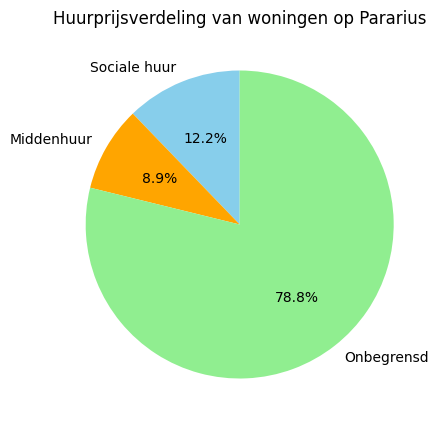

In [38]:
import matplotlib.pyplot as plt

# Filter de huursegmenten
sociale_huur = pararius[pararius["Huurprijs"] <= 879.66]
middenhuur = pararius[(pararius['Huurprijs'] > 879.66) & (pararius['Huurprijs'] <= 1165.81)]
onbegrensd = pararius[pararius["Huurprijs"] > 1165.81]

# Bereken het aantal woningen per segment
segment_counts = [len(sociale_huur), len(middenhuur), len(onbegrensd)]
segment_labels = ['Sociale huur', 'Middenhuur', 'Onbegrensd']

# Maak de taartdiagram
plt.figure(figsize=(5, 5))
plt.pie(segment_counts, labels=segment_labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange', 'lightgreen'])
plt.title("Huurprijsverdeling van woningen op Pararius")

plt.show()

Wat is de verdeling van de prijs en aantal vierkante meter oppervlakte voor middenhuurwoningen?

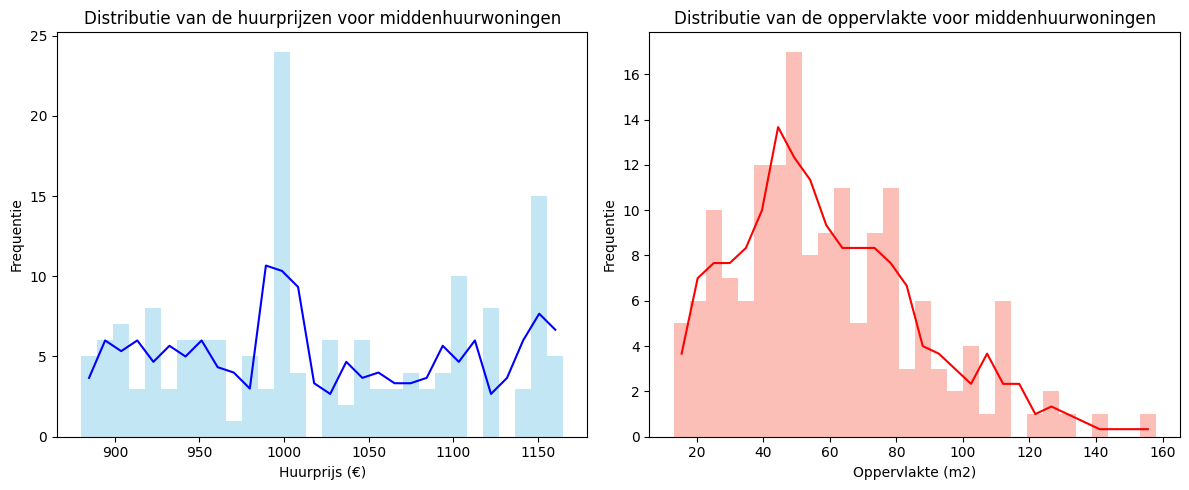

In [39]:
# Data voorbereiden en NaN waarden verwijderen
huurprijs = middenhuur['Huurprijs'].dropna()
m2 = middenhuur['m2'].dropna()

plt.figure(figsize=(12, 5))

# Histogram voor de huurprijs
plt.subplot(1, 2, 1)
count_huurprijs, bins_huurprijs, _ = plt.hist(huurprijs, bins=30, alpha=0.5, color="skyblue")
center_huurprijs = (bins_huurprijs[:-1] + bins_huurprijs[1:]) / 2
smoothed_huurprijs = np.convolve(count_huurprijs, np.ones(3)/3, mode='same')
plt.plot(center_huurprijs, smoothed_huurprijs, color="blue")
plt.title("Distributie van de huurprijzen voor middenhuurwoningen")
plt.xlabel("Huurprijs (€)")
plt.ylabel("Frequentie")

# Histogram voor de oppervlakte
plt.subplot(1, 2, 2)
count_m2, bins_m2, _ = plt.hist(m2, bins=30, alpha=0.5, color="salmon")
center_m2 = (bins_m2[:-1] + bins_m2[1:]) / 2
smoothed_m2 = np.convolve(count_m2, np.ones(3)/3, mode='same')
plt.plot(center_m2, smoothed_m2, color="red")
plt.title("Distributie van de oppervlakte voor middenhuurwoningen")
plt.xlabel("Oppervlakte (m2)")
plt.ylabel("Frequentie")

plt.tight_layout()
plt.show()

In welke gemeenten staan de meeste middenhuurwoningen?

In [40]:
top_5_gemeenten= middenhuur["Stad"].value_counts().head(5)

print(top_5_gemeenten)

Stad
groningen     18
rotterdam     13
maastricht     8
eindhoven      7
nijmegen       5
Name: count, dtype: int64


Voor woningen **boven de 186 punten** bestaat er geen grens voor de maximale huurprijs die gevraagd mag worden. Huurbazen hebben hierdoor een drijfveer om meer dan 186 punten te halen, maar is dit wel altijd terecht? We kijken naar woningen die net buiten het middenhuursegment vallen om het puntenaantal verder te analyseren.

*Let op dat voor sommige locaties niet alle informatie beschikbaar is, waardoor het aantal punten niet altijd even betrouwbaar is.*

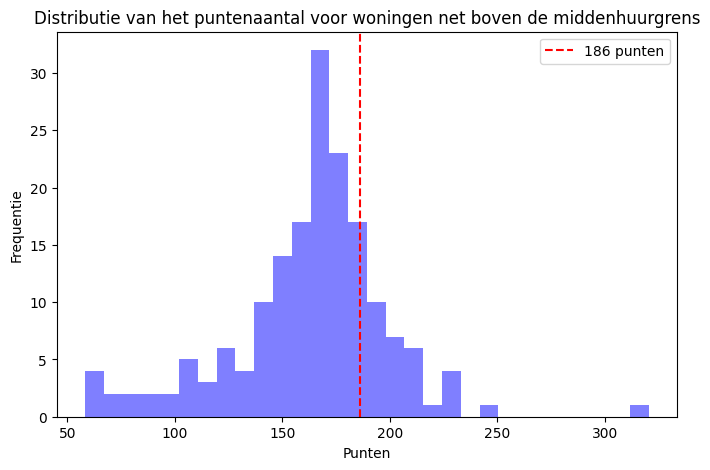

In [41]:
boven_middenhuur = pararius[(pararius['Huurprijs'] > 1165.81) & (pararius['Huurprijs'] <= 1400)]
boven_middenhuur = boven_middenhuur.sort_values(by="Punten", ascending=True)

# Bekijk de verdeling van het aantal punten
plt.figure(figsize=(8, 5))
plt.hist(boven_middenhuur["Punten"].dropna(), bins=30, color="blue", alpha=0.5)
plt.axvline(x=186, color='red', linestyle='--', linewidth=1.5, label="186 punten")
plt.title("Distributie van het puntenaantal voor woningen net boven de middenhuurgrens")
plt.xlabel("Punten")
plt.ylabel("Frequentie")
plt.legend()

plt.show()

Hoeveel woningen net boven de middenhuurgrens hebben volgens onze schatting een puntenaantal minder dan 186, wat kan betekenen dat de huurprijs te hoog is?

In [42]:
punten_onder_186 = boven_middenhuur[boven_middenhuur["Punten"] < 186].shape[0]

percentage_onder_186 = (punten_onder_186 / boven_middenhuur.shape[0]) * 100

print(f"Percentage woningen net boven de middenhuurgrens met een puntenaantal lager dan 186: {percentage_onder_186:.2f}%")

Percentage woningen net boven de middenhuurgrens met een puntenaantal lager dan 186: 77.46%


Hoeveel woningen net boven de middenhuurgrens hebben een tijdelijk huurcontract?

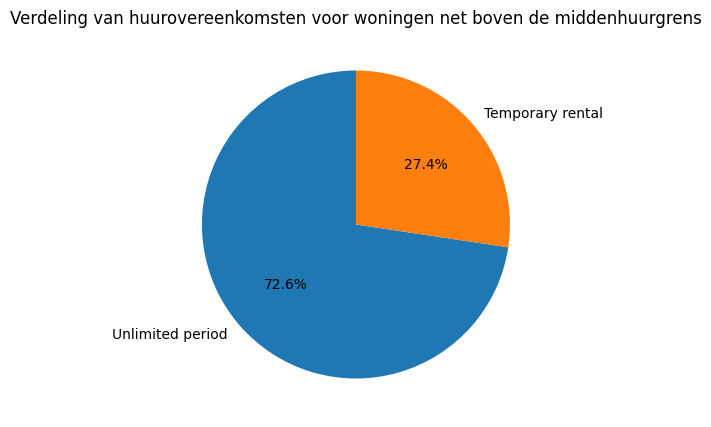

In [43]:
huurovereenkomsten = boven_middenhuur['Huurovereenkomst'].value_counts()

# Plot de taartdiagram
plt.figure(figsize=(5, 5))
plt.pie(huurovereenkomsten, labels=huurovereenkomsten.index, autopct='%1.1f%%', startangle=90)
plt.title("Verdeling van huurovereenkomsten voor woningen net boven de middenhuurgrens")

plt.show()

In [44]:
# boven_middenhuur.to_csv("../data/clean/boven_middenhuur_punten.csv", index=False)
# middenhuur.to_csv("../data/clean/middenhuur_punten.csv", index=False)
# pararius.to_csv("../data/clean/pararius_punten.csv", index=False)